<a href="https://colab.research.google.com/github/Karthika298/Binary_classification-CNN/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [2]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers , layers, applications

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
drive_path = '/content/drive/MyDrive/autism/AutismDataset'
print(os.listdir(drive_path))


['test', 'train']


## Creating dataframes for train and Test

In [5]:
filenames = os.listdir("/content/drive/MyDrive/autism/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
test_filenames = os.listdir("/content/drive/MyDrive/autism/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [8]:
from keras.applications import VGG16

# Load the pre-trained VGG16 model (excluding the top fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()
image_size = 224
input_shape = (image_size, image_size, 3)


epochs = 20
batch_size = 16

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 12846081 (49.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [9]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [10]:
# Training Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/autism/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [11]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/autism/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


In [12]:
#Fit Model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)


<ipython-input-12-d06c556e144e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
142/142 [==============================] - 1074s 7s/step - loss: 1.4791 - accuracy: 0.6093 - val_loss: 0.5097 - val_accuracy: 0.7750
Epoch 2/20
142/142 [==============================] - 42s 296ms/step - loss: 0.5991 - accuracy: 0.6771 - val_loss: 0.4779 - val_accuracy: 0.7958
Epoch 3/20
142/142 [==============================] - 44s 309ms/step - loss: 0.5658 - accuracy: 0.6978 - val_loss: 0.4845 - val_accuracy: 0.7708
Epoch 4/20
142/142 [==============================] - 42s 297ms/step - loss: 0.5371 - accuracy: 0.7436 - val_loss: 0.5207 - val_accuracy: 0.7042
Epoch 5/20
142/142 [==============================] - 42s 295ms/step - loss: 0.5359 - accuracy: 0.7401 - val_loss: 0.4744 - val_accuracy: 0.8000
Epoch 6/20
142/142 [==============================] - 43s 300ms/step - loss: 0.5056 - accuracy: 0.7502 - val_loss: 0.4706 - val_accuracy: 0.7792
Epoch 7/20
142/142 [==============================] - 42s 295ms/step - loss: 0.4981 - accuracy: 0.7590 - val_loss: 0.4225 - val_acc

In [13]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

<ipython-input-13-5bf9ded073bc>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.800000  ;  loss = 0.427432 


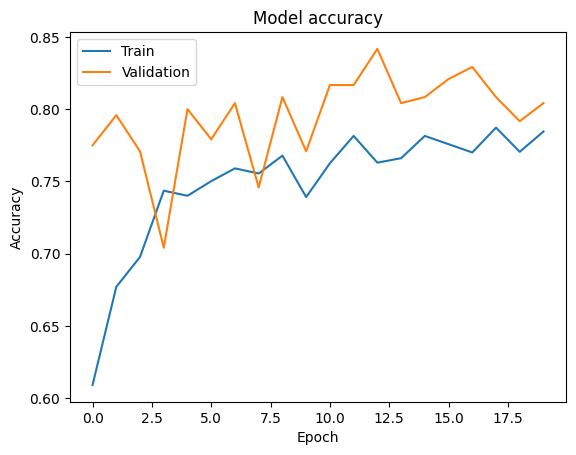

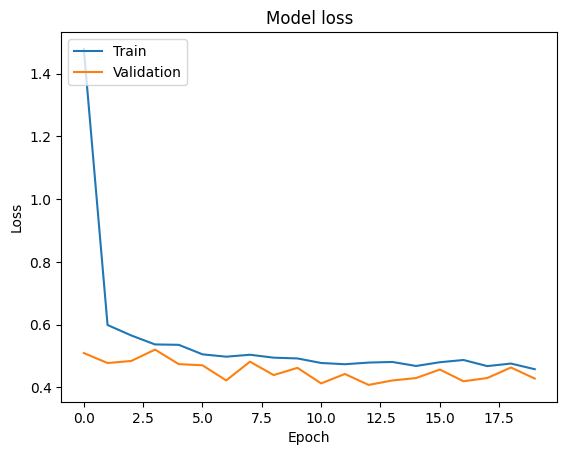

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
